In [211]:
# Main repo here for pytorch
# https://github.com/timesler/facenet-pytorch

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from facenet_pytorch import InceptionResnetV1, training
from torch.optim.lr_scheduler import MultiStepLR

plt.ion()   # interactive mode

def get_norm_params(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        #transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean_train, std=std_train)
    ]),
    'val': transforms.Compose([
        transforms.Resize((128,128)),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean_val, std=std_val)
    ]),
}

data_dir = './faces/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])           for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True)       for x in ['train', 'val']}

#mean_train, std_train = get_norm_params(dataloaders['train'])
#mean_val, std_val = get_norm_params(dataloaders['val'])

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

print(dataloaders['train'])

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model_ft = InceptionResnetV1(pretrained='vggface2', device=device, classify= True, num_classes=3)
print(model_ft.device)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}
train_loader = dataloaders['train']
val_loader = dataloaders['val']
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])


print('\n\nInitial')
print('-' * 10)
model_ft.eval()
training.pass_epoch(
    model_ft, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
)

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model_ft.train()
    training.pass_epoch(
        model_ft, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
    )

    model_ft.eval()
    training.pass_epoch(
        model_ft, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
    )


model_path = "trained_model.pt"
print("Saving model "+model_path)
torch.save(model_ft.state_dict(), model_path)


{'train': 318, 'val': 78}
['p1', 'p2', 'random_person']
mps
mps


Initial
----------
Valid |    20/20   | loss:    1.3066 | fps:  107.7150 | acc:    0.2875   

Epoch 1/10
----------
Train |    80/80   | loss:    0.8136 | fps:   24.5717 | acc:    0.7219   
Valid |    20/20   | loss:    0.2611 | fps:  121.8521 | acc:    0.9000   

Epoch 2/10
----------
Train |    80/80   | loss:    0.4246 | fps:   25.3492 | acc:    0.8687   
Valid |    20/20   | loss:    0.7171 | fps:  120.5046 | acc:    0.7125   

Epoch 3/10
----------
Train |    80/80   | loss:    0.4104 | fps:   25.9649 | acc:    0.8875   
Valid |    20/20   | loss:    0.2131 | fps:  125.7062 | acc:    0.9500   

Epoch 4/10
----------
Train |    80/80   | loss:    0.3392 | fps:   25.5878 | acc:    0.9156   
Valid |    20/20   | loss:    0.1259 | fps:  128.2951 | acc:    0.9750   

Epoch 5/10
----------
Train |    80/80   | loss:    0.2999 | fps:   25.2003 | acc:    0.9062   
Valid |    20/20   | loss:    0.4035 | fps:  129.4202 | acc:

In [166]:
torch.save(model_ft, 'train_model_full.pt')

In [208]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std  = np.array([0.229, 0.224, 0.225])
    #inp  = std * inp + mean
    #inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(5)  # pause a bit so that plots are updated

def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #use these lines for advnet
            outputs = model(inputs)
            print(outputs)
            probs = torch.nn.functional.softmax(outputs.float(),dim=1)
            max_value,max_value_index_list = torch.max(probs,1)
            print('outputs',outputs)
            print('probs',probs)
            print('max_values',max_value)
            print('max_value_indexes',max_value_index_list)
            #print(probs)
            for j in range(inputs.size()[0]):
                max_value_index = max_value_index_list[j]
                prob_val = probs[j][max_value_index]
                classname = class_names[max_value_index]
                
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classname} w/ {round(float(prob_val * 100),2)}%')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
inputimg = torch.rand(2, 3, 256, 256, requires_grad=True, device=device)
optimizer = optim.Adam([inputimg], lr=0.001)
target_class = 0
iteration = 0
MAX_ITERATION = 1000
probs_sum = 0
while iteration < MAX_ITERATION:
    outputs = model_ft(inputimg)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    loss = -torch.log(probs[:, target_class]).sum()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    iteration += 1
    if iteration % 20 == 0:
        print(f"Iteration {iteration}, Target class probability: {probs[:, target_class].detach()}; Total Probability: {probs_sum}")
    if iteration == MAX_ITERATION:
        break
    probs_sum = torch.sum(probs[:, target_class].detach())

Iteration 20, Target class probability: tensor([0.7631, 0.7569], device='mps:0'); Total Probability: 1.499353289604187
Iteration 40, Target class probability: tensor([0.9002, 0.8974], device='mps:0'); Total Probability: 1.788815975189209
Iteration 60, Target class probability: tensor([0.9483, 0.9494], device='mps:0'); Total Probability: 1.8947961330413818
Iteration 80, Target class probability: tensor([0.9647, 0.9680], device='mps:0'); Total Probability: 1.931567907333374
Iteration 100, Target class probability: tensor([0.9725, 0.9771], device='mps:0'); Total Probability: 1.9489519596099854
Iteration 120, Target class probability: tensor([0.9776, 0.9824], device='mps:0'); Total Probability: 1.9595987796783447
Iteration 140, Target class probability: tensor([0.9813, 0.9858], device='mps:0'); Total Probability: 1.9667844772338867
Iteration 160, Target class probability: tensor([0.9841, 0.9881], device='mps:0'); Total Probability: 1.9719725847244263
Iteration 180, Target class probability

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4559664..1.525563].


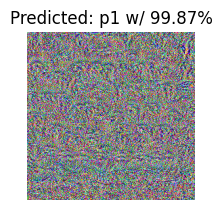

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6939078..1.5629828].


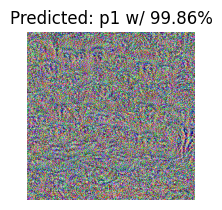

In [165]:
import random
import string
from torchvision.utils import save_image
import pickle
num_images = 5
images_so_far = 0
for j in range(inputimg.size(0)):
    images_so_far += 1
    ax = plt.subplot(num_images // 2, 2, images_so_far)
    ax.axis('off')
    output_class = torch.argmax(probs[j])
    ax.set_title(f'Predicted: {class_names[output_class]} w/ {round(float(probs[j, output_class] * 100), 2)}%')
    imshow(inputimg.cpu().data[j])
    random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
    with open(f'data/{j}.pickle', 'wb') as handle:
        pickle.dump(inputimg.cpu().data[j],handle)

    if images_so_far == num_images:
        break


torch.Size([4])


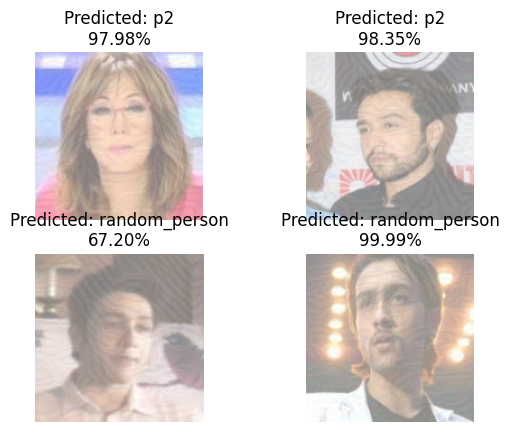

In [118]:
from torchattacks import PGD

atk = PGD(model_ft, eps=8/255, alpha=2/225, steps=10000, random_start=True)
x = iter(dataloaders['val'])
images,labels = x.__next__()


#noise = torch.rand(2,3, 256, 256, requires_grad=True, device=device)
noise = images.float()
print(labels.shape)
#atk.set_mode_targeted_by_function(target_map_function=lambda dataloaders, labels:(labels+1))
adv_images = atk(noise,torch.tensor([0,0,0,0]))

adv_pred = model_ft(adv_images)
num_images = adv_pred.size(0)

probs = torch.nn.functional.softmax(adv_pred, dim=1)
for i in range(num_images):
    plt.subplot(num_images // 2, 2, i + 1)
    plt.axis('off')
    output_class = torch.argmax(probs[i])
    plt.title(f'Predicted: {class_names[output_class]}\n{probs[i, output_class]:.2%}')
    img = adv_images[i].cpu().data
    img = (img + 1) / 2  
    img = img.permute(1, 2, 0)  
    plt.imshow(img)

Iteration 0, Target class probability: 0.0928
Iteration 10, Target class probability: 0.2731
Iteration 20, Target class probability: 0.5008
Iteration 30, Target class probability: 0.7021
Iteration 40, Target class probability: 0.8724
Iteration 50, Target class probability: 0.9172
Iteration 60, Target class probability: 0.9513
Iteration 70, Target class probability: 0.9645
Iteration 80, Target class probability: 0.9748
Iteration 90, Target class probability: 0.9737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..3.4178135].


torch.Size([2, 3, 128, 128])


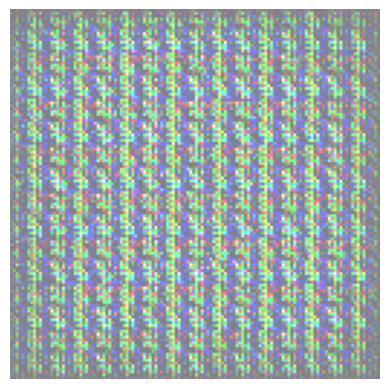

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..3.431687].


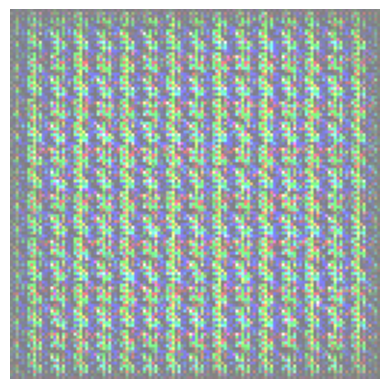

Iteration 0, Target class probability: 0.0007
Iteration 10, Target class probability: 0.0006
Iteration 20, Target class probability: 0.0036
Iteration 30, Target class probability: 0.0873
Iteration 40, Target class probability: 0.2937
Iteration 50, Target class probability: 0.5211
Iteration 60, Target class probability: 0.7073
Iteration 70, Target class probability: 0.8899
Iteration 80, Target class probability: 0.9612
Iteration 90, Target class probability: 0.9774


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..10.541643].


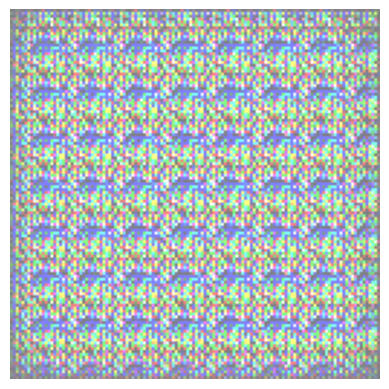

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..10.481125].


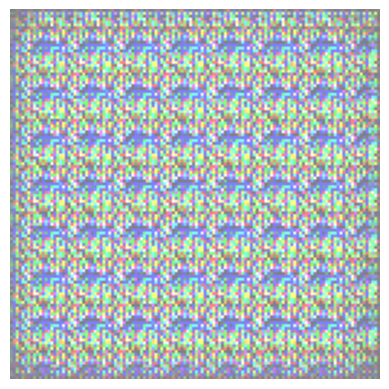

In [215]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.linear1 = nn.Linear(latent_dim, 512 * 4 * 4)
        
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)

    def forward(self, x):
        #fix this later
        x = self.linear1(x)
        x = x.view(-1, 512, 4, 4)
        
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = F.relu((self.deconv5(x)))
        return x

def train_generator(generator, classifier, target_class, num_iterations=50, batch_size=2, latent_dim=100, device="cpu"):
    generator = generator.to(device)
    classifier = classifier.to(device)
    
    for param in classifier.parameters():
        param.requires_grad = False
    
    optimizer = optim.Adam(generator.parameters(), lr=0.0001)
    
    for iteration in range(num_iterations):
        optimizer.zero_grad()
        
        z = torch.randn(batch_size, latent_dim).to(device)
        
        fake_images = generator(z)
        
        outputs = classifier(fake_images)
        probs = F.softmax(outputs, dim=1)
        
        loss = -torch.log(probs[:, target_class]).mean()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Target class probability: {probs[:, target_class].mean().item():.4f}")
            
    return generator

def generate_images(generator, num_images=2, latent_dim=100, device='mps'):
    generator.eval()
    
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated = generator(z)
        
    return generated

def display_generated_images(images, classifier, class_names):
    classifier.eval()
    
    with torch.no_grad():
        outputs = classifier(images)
        probs = F.softmax(outputs, dim=1)
    
    num_images = images.size(0)
    for i in range(num_images):
        #plt.subplot(num_images // 2, 2, i + 1)
        plt.axis('off')
        #output_class = torch.argmax(probs[i])
        #plt.title(f'Predicted: {class_names[output_class]}\n{probs[i, output_class]:.2%}')
        img = images[i].cpu().data
        img = (img + 1) / 2  
        img = img.permute(1, 2, 0)  
        plt.imshow(img)
        plt.show()
    
    #plt.tight_layout()
    
latent_dim = 512 * 4 * 4
generator = Generator(latent_dim=latent_dim)
generator = train_generator(generator, model_ft, target_class=0,num_iterations=100,device=device, latent_dim=latent_dim)
generated_images = generate_images(generator, num_images=2, latent_dim=latent_dim)
print(generated_images.shape)
display_generated_images(generated_images, model_ft, class_names)

generator = train_generator(generator, model_ft, target_class=1,num_iterations=100,device=device, latent_dim=latent_dim)
generated_images = generate_images(generator, num_images=2, latent_dim=latent_dim)
display_generated_images(generated_images, model_ft, class_names)

In [ ]:
#visualize_model(model_ft)

#create a model that generates 3 by 256 by 256 images to act as an adversarial net



RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

<Figure size 640x480 with 0 Axes>